In [1]:
import os

from tqdm import tqdm
from PIL import Image
import numpy as np

import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

import torch
import torch.nn.functional as F
import torchvision.transforms as transforms

from data.base_dataset import Normalize_image
from utils.saving_utils import load_checkpoint_mgpu, load_checkpoint

from networks import U2NET
from utils.visualize import display_top_masks

/opt/conda/envs/segment/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cpu"

image_dir = "../../data/imaterialist/test"
result_dir = "output_images"
if not os.path.exists(result_dir):
    os.makedirs(result_dir)
checkpoint_path = os.path.join("results/training_cloth_segm_u2net_exp1",
                               "latest.pth")
do_palette = True

In [3]:
def get_palette(num_cls):
    """Returns the color map for visualizing the segmentation mask.
    Args:
        num_cls: Number of classes
    Returns:
        The color map
    """
    n = num_cls
    palette = [0] * (n * 3)
    for j in range(0, n):
        lab = j
        palette[j * 3 + 0] = 0
        palette[j * 3 + 1] = 0
        palette[j * 3 + 2] = 0
        i = 0
        while lab:
            palette[j * 3 + 0] |= ((lab >> 0) & 1) << (7 - i)
            palette[j * 3 + 1] |= ((lab >> 1) & 1) << (7 - i)
            palette[j * 3 + 2] |= ((lab >> 2) & 1) << (7 - i)
            i += 1
            lab >>= 3
    return palette

In [4]:
transforms_list = []
transforms_list += [transforms.ToTensor()]
transforms_list += [Normalize_image(0.5, 0.5)]
transform_rgb = transforms.Compose(transforms_list)

net = U2NET(in_ch=3, out_ch=2)
# net = load_checkpoint_mgpu(net, checkpoint_path)
net = load_checkpoint(net, checkpoint_path)
net = net.to(device)
net = net.eval()

palette = get_palette(4)

----checkpoints loaded from path: results/training_cloth_segm_u2net_exp1/latest.pth----


  0%|          | 0/3193 [00:00<?, ?it/s][W NNPACK.cpp:80] Could not initialize NNPACK! Reason: Unsupported hardware.
/opt/conda/envs/segment/lib/python3.8/site-packages/torch/nn/functional.py:3325: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/opt/conda/envs/segment/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


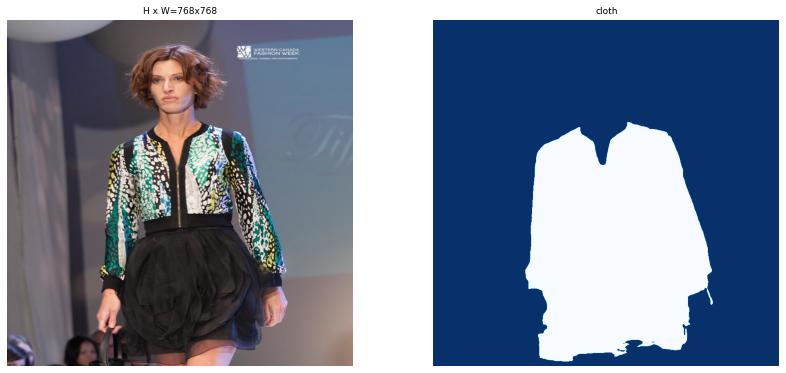

  0%|          | 1/3193 [00:05<4:56:35,  5.58s/it]

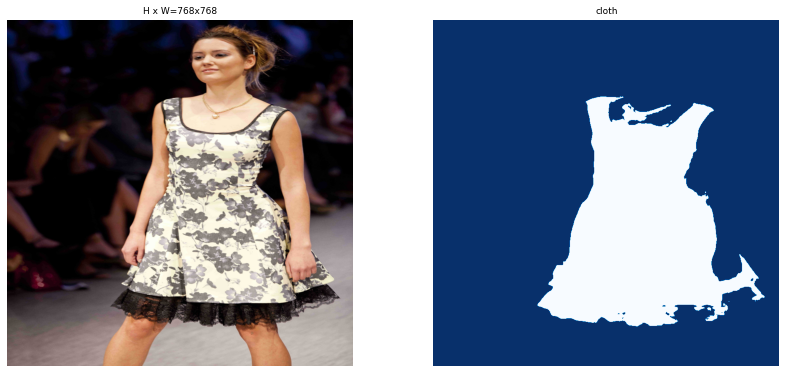

  0%|          | 2/3193 [00:10<4:40:30,  5.27s/it]

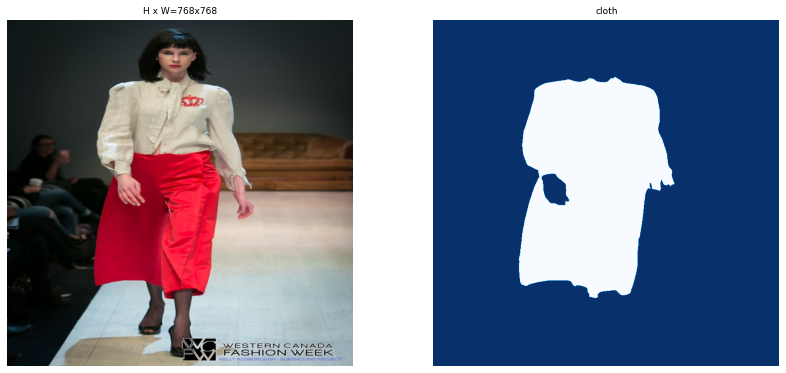

  0%|          | 3/3193 [00:15<4:31:43,  5.11s/it]

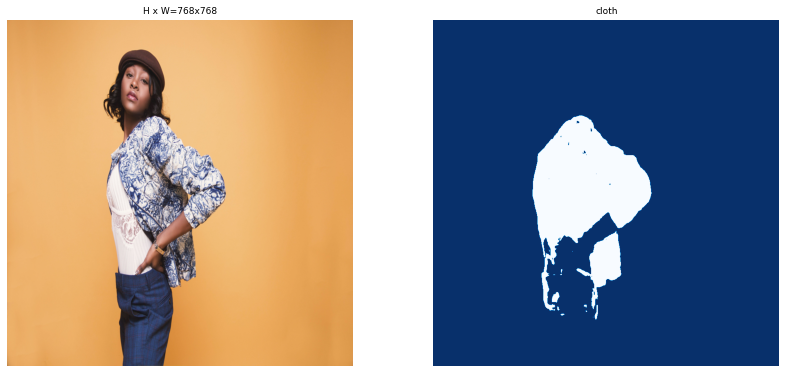

  0%|          | 4/3193 [00:20<4:29:12,  5.06s/it]

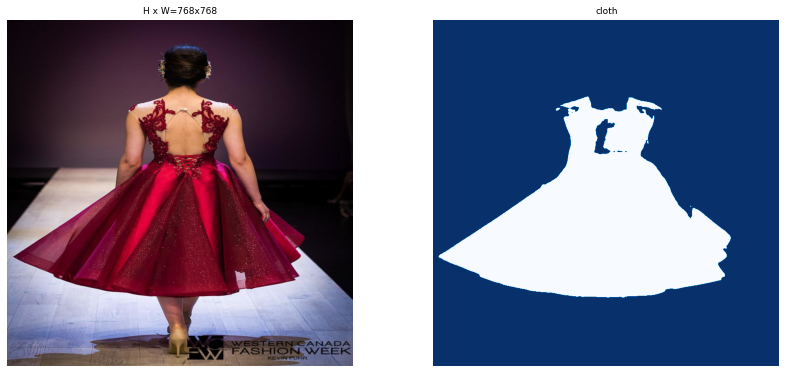

  0%|          | 5/3193 [00:25<4:19:31,  4.88s/it]

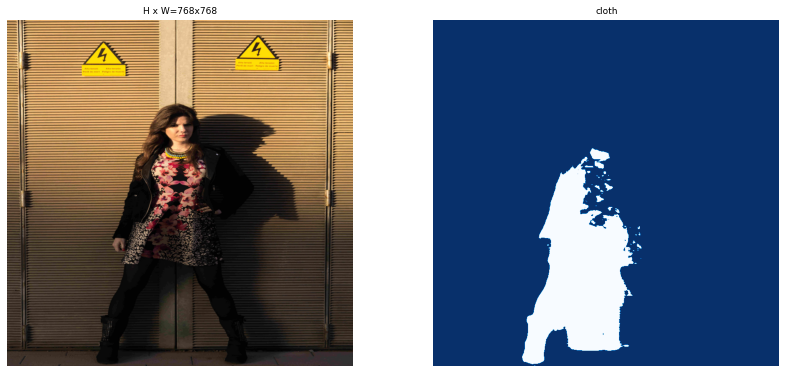

  0%|          | 6/3193 [00:30<4:23:42,  4.96s/it]

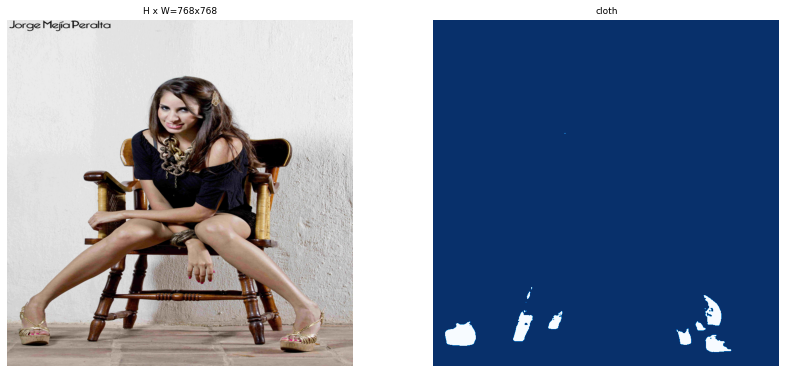

  0%|          | 7/3193 [00:35<4:32:54,  5.14s/it]

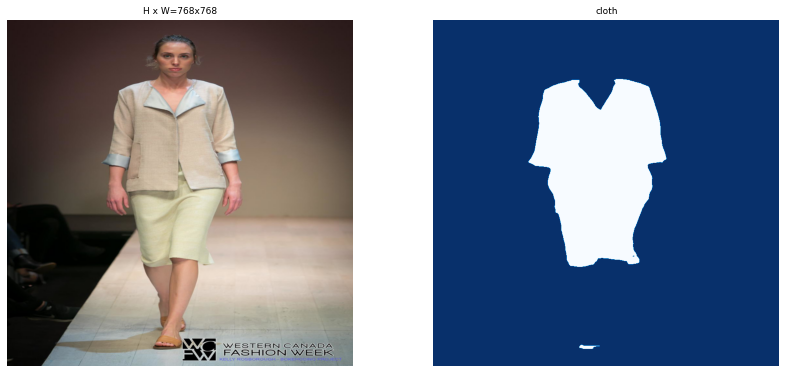

  0%|          | 8/3193 [00:40<4:27:26,  5.04s/it]

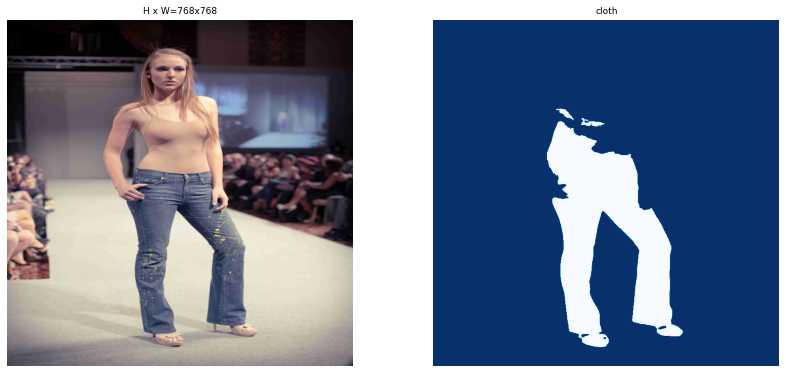

  0%|          | 9/3193 [00:45<4:27:51,  5.05s/it]

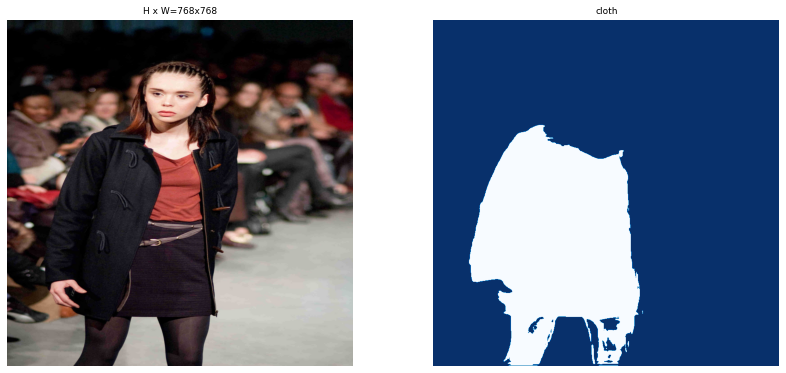

  0%|          | 10/3193 [00:50<4:26:01,  5.01s/it]

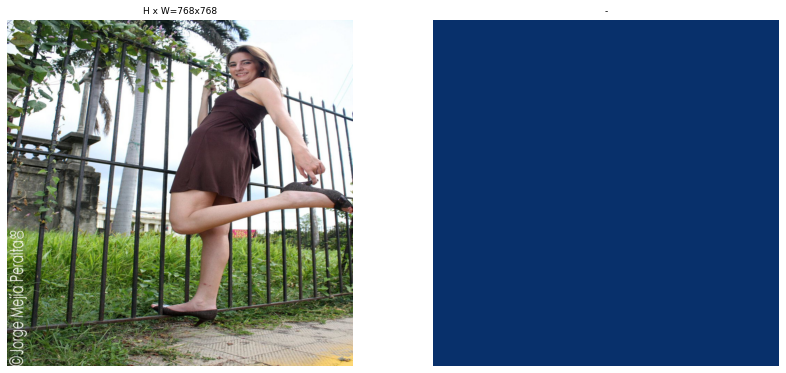

  0%|          | 11/3193 [00:55<4:26:05,  5.02s/it]

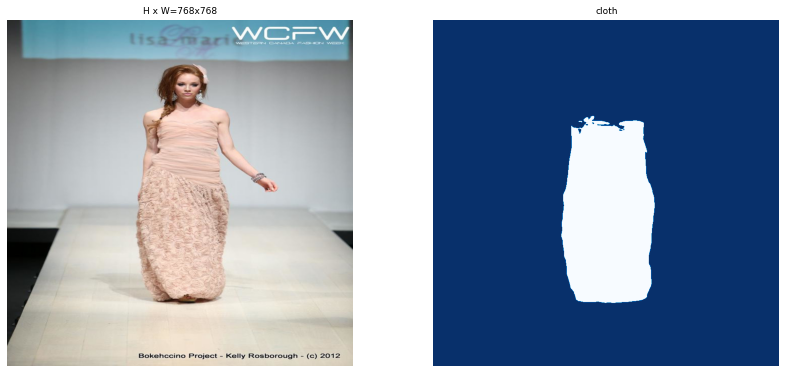

  0%|          | 12/3193 [01:00<4:28:53,  5.07s/it]

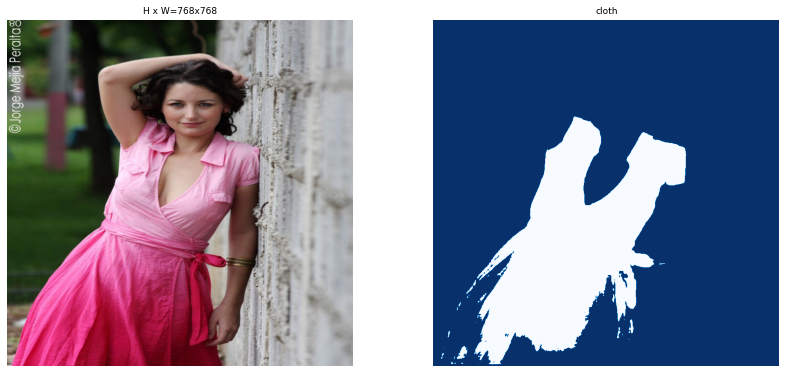

  0%|          | 13/3193 [01:05<4:23:32,  4.97s/it]

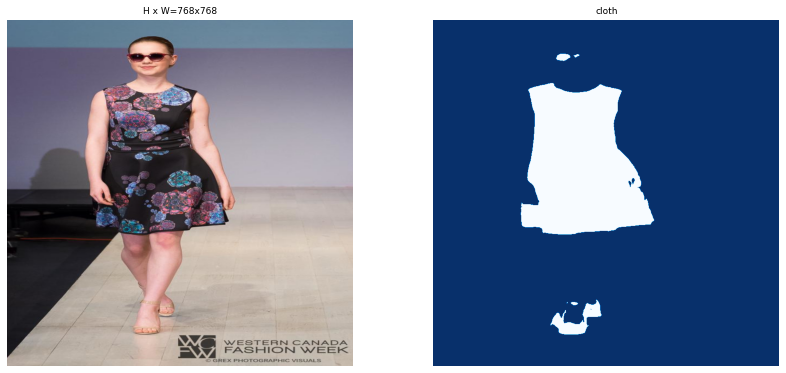

  0%|          | 14/3193 [01:10<4:30:25,  5.10s/it]

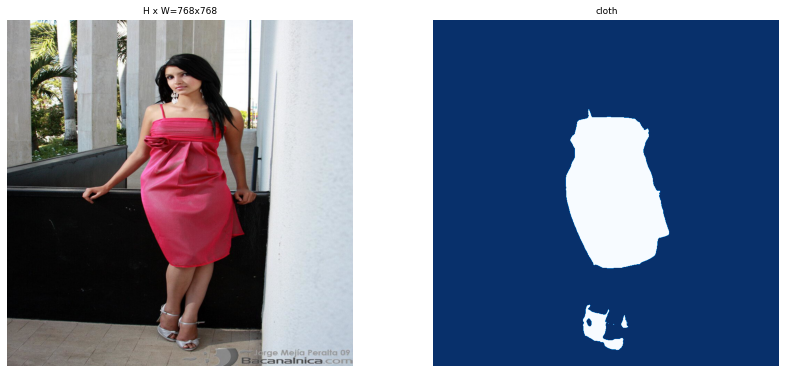

  0%|          | 15/3193 [01:16<4:31:24,  5.12s/it]

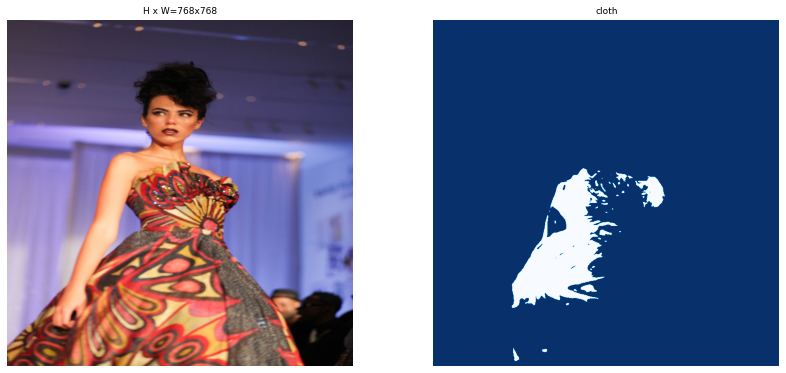

  1%|          | 16/3193 [01:21<4:42:10,  5.33s/it]

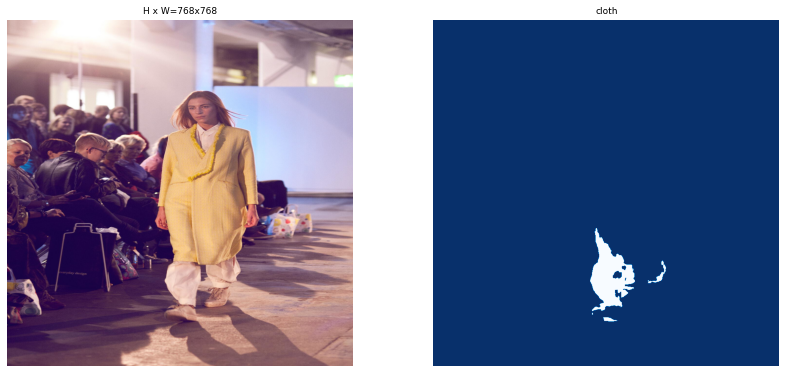

  1%|          | 17/3193 [01:27<4:40:26,  5.30s/it]

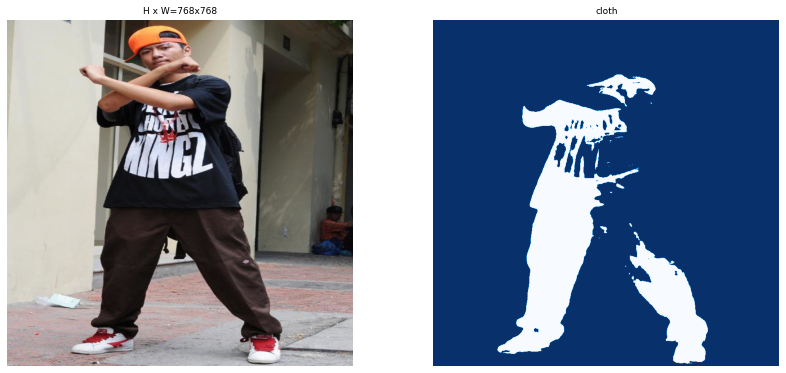

  1%|          | 18/3193 [01:31<4:31:13,  5.13s/it]

KeyboardInterrupt: 

In [5]:
images_list = sorted(os.listdir(image_dir))
pbar = tqdm(total=len(images_list))
for image_name in images_list:
    img = Image.open(os.path.join(image_dir, image_name)).convert("RGB")
    img_size = img.size
    concat_img = Image.new(size=(img_size[0] * 2, img_size[1]), 
                           mode="RGB",
                           color=(255, 255, 255))
    concat_img.paste(img, (0, 0))
    img = img.resize((192 * 4, 192 * 4), Image.BICUBIC)

    image_tensor = transform_rgb(img)
    image_tensor = torch.unsqueeze(image_tensor, 0)

    output_tensor = net(image_tensor.to(device))
    output_tensor = F.log_softmax(output_tensor[0], dim=1)
    output_tensor = torch.max(output_tensor, dim=1, keepdim=True)[1]
    output_tensor = torch.squeeze(output_tensor, dim=0)
    output_tensor = torch.squeeze(output_tensor, dim=0)
    output_arr = output_tensor.cpu().numpy()
    output_img = Image.fromarray(output_arr.astype("uint8"), mode="L")
    
    # print(output_arr.reshape((output_arr.shape[0], output_arr.shape[1], 1)))
    display_top_masks(np.array(img), 
                      output_arr.reshape((output_arr.shape[0], output_arr.shape[1], 1)),
                      [1], ["bg", "cloth"], limit=1)
    
    # if do_palette:
    #     output_img.putpalette(palette)
    # output_img = output_img.resize(img_size, Image.BICUBIC)
    # concat_img.paste(output_img, (img_size[0], 0))
    # concat_img.save(os.path.join(result_dir, image_name[:-3] + "png"))
    pbar.update(1)

pbar.close()